In [2]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import ConvClassifier
from pclib.nn.layers import Conv2d
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity
from pclib.utils.customdataset import PreloadedDataset

In [3]:
seed = 42
# For reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device

device(type='cuda')

In [81]:
torch.manual_seed(seed)
class PadTransform(object):
    def __call__(self, img):
        return F.pad(img, (2, 2, 2, 2), mode='constant', value=0)

class TransformTensorDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets, transform):
        self.transform = transform
        self.data = data
        self.targets = targets
        assert data.size(0) == targets.size(0)

    def __getitem__(self, index):
        return self.transform(self.data[index]), self.targets[index]

    def __len__(self):
        return self.data.size(0)

transform = transforms.Compose([
    # transforms.ToTensor(),
    # PadTransform(),
])

train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

import numpy as np
dataset = datasets.CIFAR10('../Datasets/', train=True, download=False)

data = torch.tensor(dataset.data).permute(0, 3, 1, 2)/255.0
targets = torch.tensor(dataset.targets)
train_dataset = TransformTensorDataset(data, targets, train_transform)
# print(train_dataset[0:10][0].shape)

train_dataset[:][0].shape

# dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

# VAL_RATIO = 0.2
# val_len = int(len(dataset) * VAL_RATIO)
# train_len = len(dataset) - val_len
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
# train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
# INPUT_SHAPE = 784
# NUM_CLASSES = 10

torch.Size([50000, 3, 32, 32])

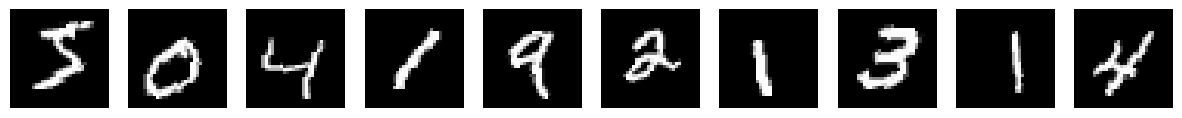

AttributeError: 'TransformTensorDataset' object has no attribute 'transformed_images'

In [52]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [5]:
torch.manual_seed(seed)

model_name = 'supervised-bias'
model = ConvClassifier(
    bias=True, 
    symmetric=True, 
    actv_fn=identity,
    steps=60,
    gamma=0.1,
).to(device)

In [6]:
# Train Loop
NUM_EPOCHS = 30
BATCH_SIZE = 1000

log_dir = f'examples/mnist/out/logs/{model_name}'
log_dir = None
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.0001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    optim='AdamW',
    log_dir=log_dir,
)

NUM_EPOCHS = 20
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.00001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    optim='AdamW',
    log_dir=log_dir,
)

KeyboardInterrupt: 

In [7]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=100, flatten=False)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.10033333333333333 | error_rate: 89.97 %


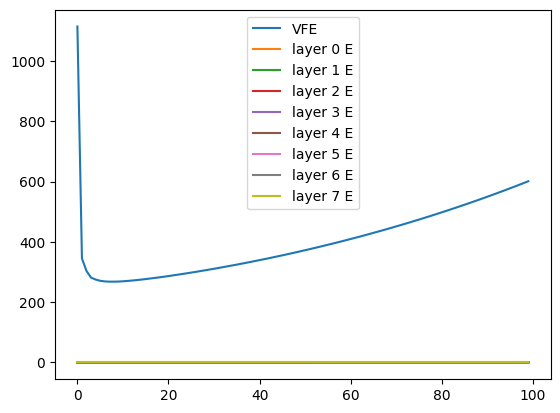

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


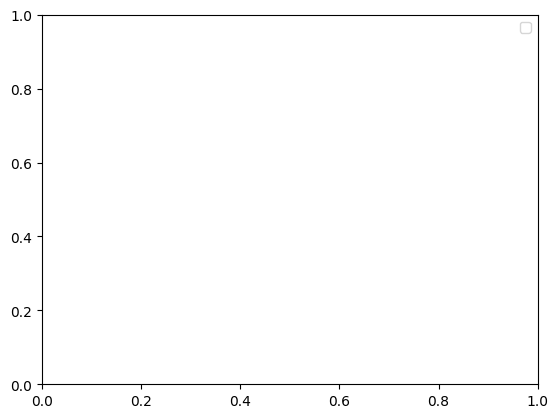

In [17]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images
y = format_y(y, 10)

vfe = track_vfe(model, x, y, 100, plot_Es=True)